In [1]:
import xarray as xr
import pandas as pd

In [2]:
unet = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/generator_models/UNET_nz_domain/EC-Earth3_hist_ssp370_unet.nc')

In [3]:
df_raw = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/outputs/raw_GCM_fields/EC-Earth3_ssp370_raw_GCM_pr.nc').sel(lat = slice(-65, -25), lon = slice(150, 200.5))
df_raw2 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/outputs/raw_GCM_fields/EC-Earth3_historical_raw_GCM_pr.nc').sel(lat = slice(-65, -25), lon = slice(150, 200.5))
df_raw['time'] = pd.to_datetime(df_raw.time.dt.strftime('%Y-%m-%d'))
df_raw2['time'] = pd.to_datetime(df_raw2.time.dt.strftime('%Y-%m-%d'))
df_raw = xr.concat([df_raw2.sel(time = slice(None, "2014")),
                    df_raw.sel(time = slice("2015",None))], dim ="time")

In [116]:
df_raw['pr'] = df_raw['pr'] * 3600 * 24

In [2]:
df_gan_perfect= xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/generator_models/wgan_nz_domain/EC-Earth3_hist_ssp370_gan_in_imprefect_applied_and_trained_510epcoh.nc')

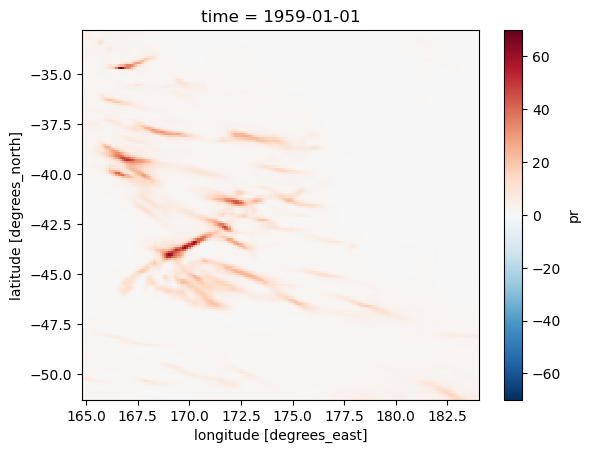

In [3]:
df_gan_perfect.isel(time =0).pr.plot()

In [353]:
df_gan_imperfect = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/generator_models/wgan_nz_domain_adv_fine_tuned_historical_future/EC-Earth3_hist_ssp370_gan_in_imprefect_applied_and_trained_280epcoh.nc')

In [354]:
df_gan_imperfect.isel(time =0).pr.plot(cmap =cmap, norm = norm)

NameError: name 'cmap' is not defined

In [423]:
rx1day_gcm = df_raw.sel(lat = slice(unet.lat.min(), unet.lat.max()), lon = slice(unet.lon.min(), unet.lon.max())).groupby('time.year').max()

In [393]:
#rx1day_unet = unet.groupby('time.year').max()
rx1day_gan_perfect = df_gan_perfect.groupby('time.year').max()
#rx1day_gan_imperfect = df_gan_imperfect.groupby('time.year').max()

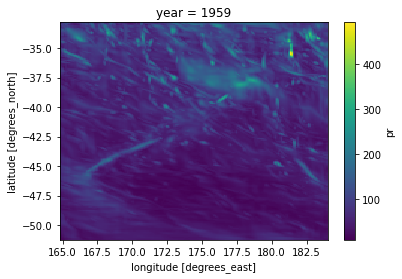

In [392]:
rx1day_gan_perfect.isel(year =0).pr.plot()


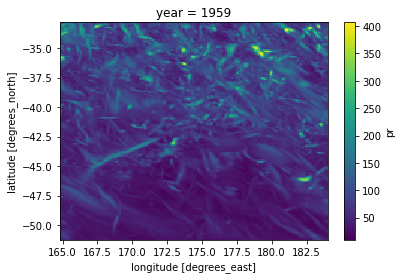

In [350]:
rx1day_gan_imperfect.isel(year =0).pr.plot()


In [242]:
cc_signal_perfect= 100 *(df_gan_perfect.sel(time = slice("2080","2099")).groupby('time.season').mean() - df_gan_perfect.sel(time = slice("1986","2005")).groupby('time.season').mean())/df_gan_perfect.sel(time = slice("1986","2005")).groupby('time.season').mean()

In [351]:
cc_signal_imperfect= 100 *(df_gan_imperfect.sel(time = slice("2080","2099")).groupby('time.season').mean() - df_gan_imperfect.sel(time = slice("1986","2005")).groupby('time.season').mean())/df_gan_imperfect.sel(time = slice("1986","2005")).groupby('time.season').mean()

In [129]:
cc_signal_unet= 100 *(unet.sel(time = slice("2080","2099")).groupby('time.season').mean() - unet.sel(time = slice("1986","2005")).groupby('time.season').mean())/unet.sel(time = slice("1986","2005")).groupby('time.season').mean()

In [229]:
cc_signal_gcm= 100 *(df_raw.sel(time = slice("2080","2099")).groupby('time.season').mean() - df_raw.sel(time = slice("1986","2005")).groupby('time.season').mean())/df_raw.sel(time = slice("1986","2005")).groupby('time.season').mean()

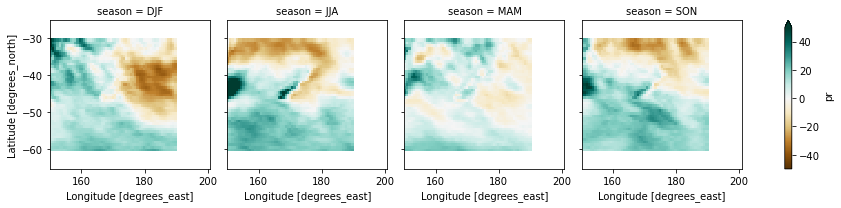

In [226]:
cc_signal_gcm.pr.plot(col ="season", col_wrap =4, cmap ='BrBG', vmin =-50, vmax =50
                     )

In [367]:
cc_signal_ = [ cc_signal, cc_signal_imperfect, cc_signal_perfect,cc_signal_unet.rename({"ML":"pr"}).isel(lead_time =0),cc_signal_gcm]

In [369]:
len(cc_signal_)

5

In [303]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cart
# cc_signal_ = [cc_signal_gcm, cc_signal, cc_signal_imperfect, cc_signal_perfect]
# # Create a 4x4 grid of subplots
# fig, axes = plt.subplots(4, 4, figsize=(15, 15), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)))

# # Loop through each subplot and plot the data
# for i in range(4):
#     for j in range(4):
#         #axes[i,j].add_feature(cart.OCEAN.with_scale('10m'), alpha =0.2, zorder =5, color ='white', ec ='k')
#         cs = cc_signal_[i].pr.isel(season =j).sel(lat = slice(-49, -33), lon = slice(165, 180)).plot( cmap='BrBG', vmin=-60, vmax=60, ax=axes[i,j], add_colorbar =False, transform = ccrs.PlateCarree())
#         axes[i,j].set_title(f"Plot {i+1}")
#         axes[i,j].coastlines('10m')
        
        

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [362]:
seasons =['DJF','MAM', 'JJA','SON']

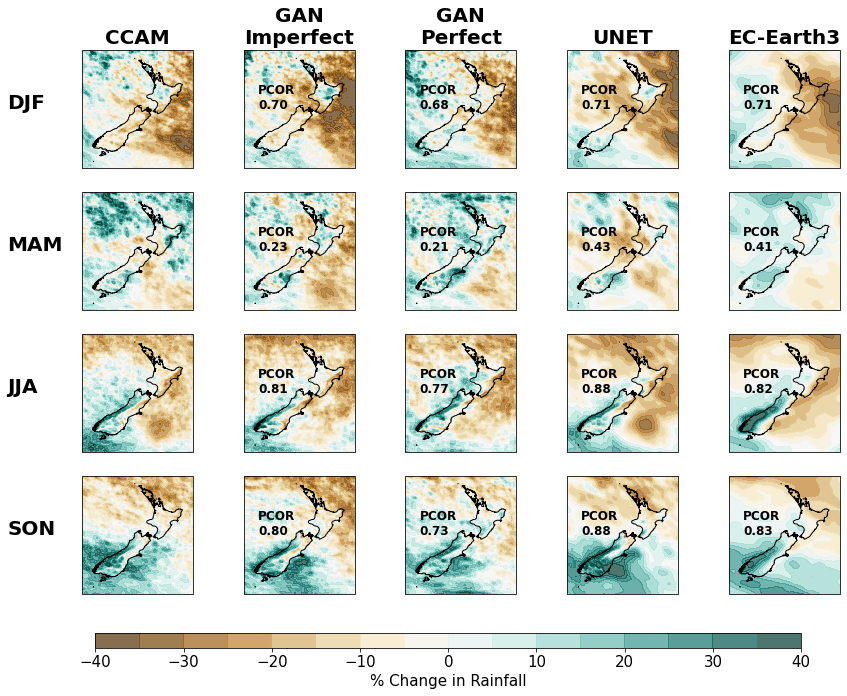

In [390]:
fig, axes = plt.subplots(4, 5, figsize=(14, 10), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=171.77)))
models =['CCAM', 'GAN\nImperfect', 'GAN\nPerfect','UNET', 'EC-Earth3']
#axes = axes.T
# Loop through each subplot and plot the data
for i in range(4):
    for j in range(5):
        # Plot the data
        #print(i,j)
        cs = cc_signal_[j].pr.sel(season=seasons[i]).sel(lat=slice(-49, -33), lon=slice(165, 180)).plot.contourf(
            cmap='BrBG', vmin=-40, vmax=40, ax=axes[i, j], add_colorbar=False, transform=ccrs.PlateCarree(),
        alpha =0.7, levels = np.arange(-40, 45, 5))
        
        # Calculate pattern correlation for each GCM
        pcor = xr.corr(
            cc_signal_[j].sel(season = seasons[i]).stack(z=['lat', 'lon']).pr.dropna("z"),
            cc_signal.sel(season = seasons[i]).stack(z=['lat', 'lon']).pr.dropna("z"),
            dim="z"
        )
        if j>0:
            axes[i,j].text(167, -41, f'PCOR\n{pcor.values:.2f}', transform = ccrs.PlateCarree(), fontsize = 12, weight ='bold', color ='k')
        # Set title with pcor value
        #axes[i, j].set_title(f"Plot {i + 1}\nSeason: {cc_signal_[i].season[j]} | Pattern Correlation: {pcor.values:.2f}", fontsize=10)
        axes[i, j].coastlines('10m')
        axes[i,j].set_title(' ')
        if j ==0:
            axes[i,j].text(155, -41, seasons[i], fontsize = 20, weight ='bold', transform = ccrs.PlateCarree())
            
        if i ==0:
            axes[i,j].set_title(models[j], fontsize =20, weight ='bold')
            



# Add a common colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # Position of colorbar
cbar = plt.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('% Change in Rainfall', fontsize=15)
cbar.ax.tick_params(labelsize=15)

# Adjust layout
#plt.tight_layout()
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/cc_signal_v2.png', dpi =500, bbox_inches ='tight')
plt.show()

In [230]:
cc_signal_gcm = cc_signal_gcm.sel(lat = slice(-60, -30), lon = slice(150, 190)).interp(lat = cc_signal_perfect.lat, lon = cc_signal_perfect.lon, method ='cubic', kwargs = dict(fill_value ='extrapolate'))

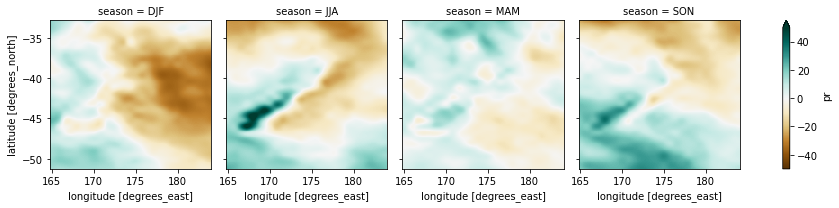

In [231]:
cc_signal_gcm.pr.plot(col ="season", col_wrap =4, cmap ='BrBG', vmin =-50, vmax =50
                     )

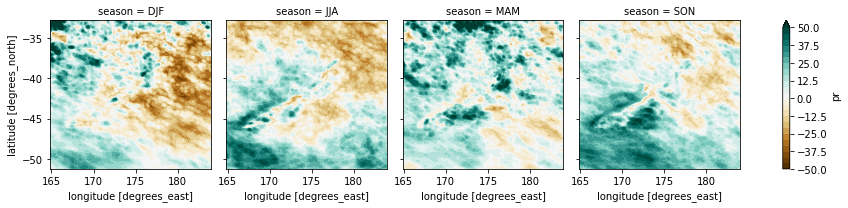

In [223]:
cc_signal_imperfect.pr.plot.contourf(col ="season", col_wrap =4, cmap ='BrBG', vmin =-50, vmax =50, levels =25)

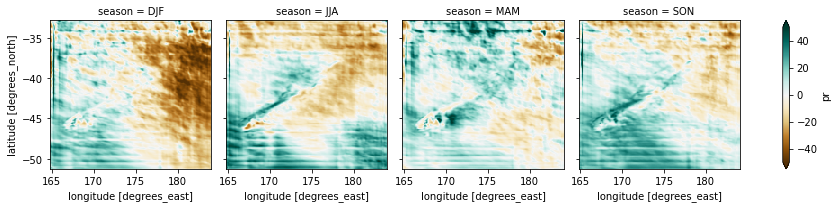

In [194]:
cc_signal_perfect.pr.plot(col ="season", col_wrap =4, cmap ='BrBG', vmin =-50, vmax =50)

In [76]:
y = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/outputs/raw_CCAM_outputs/EC-Earth3_ssp370_precip.nc')
y['time'] = pd.to_datetime(y.time.dt.strftime("%Y-%m-%d"))
y2 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/outputs/raw_CCAM_outputs/EC-Earth3_historical_precip.nc')
y2['time'] = pd.to_datetime(y2.time.dt.strftime("%Y-%m-%d"))

y = xr.concat([y2.sel(time = slice(None, "2014")), y.sel(time = slice("2015", None))], dim ="time")

In [203]:
cc_signal = 100 *(y.sel(time = slice("2080","2099")).groupby('time.season').mean() - y.sel(time = slice("1986","2005")).groupby('time.season').mean())/y.sel(time = slice("1986","2005")).groupby('time.season').mean()

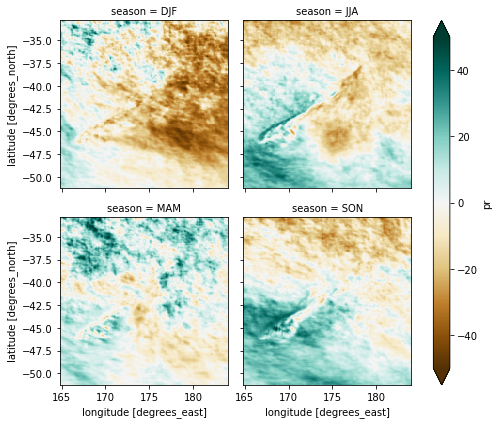

In [204]:
cc_signal.pr.plot(col = "season", col_wrap =2, cmap ='BrBG', vmin =-50, vmax =50)


In [98]:
import numpy as np

In [278]:
pcor = xr.corr(cc_signal_imperfect.stack(z =['lat','lon']).pr.dropna("z"), cc_signal.stack(z =['lat','lon']).pr.dropna("z"), dim ="z")

In [279]:
pcor


<xarray.DataArray 'pr' (season: 4)>
array([0.70997697, 0.8089599 , 0.22275458, 0.79661906])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

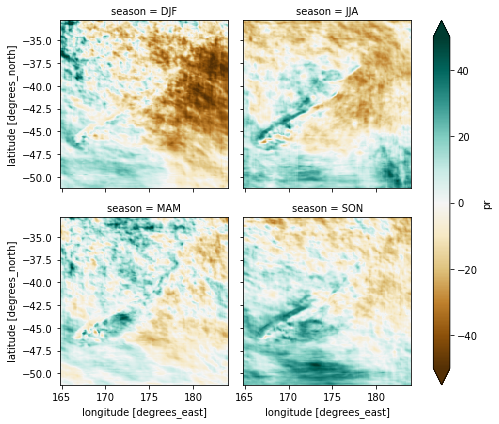

In [173]:
cc_signal_predsgan.pr.plot(col = "season", col_wrap =2, cmap ='BrBG', vmin =-50, vmax =50)


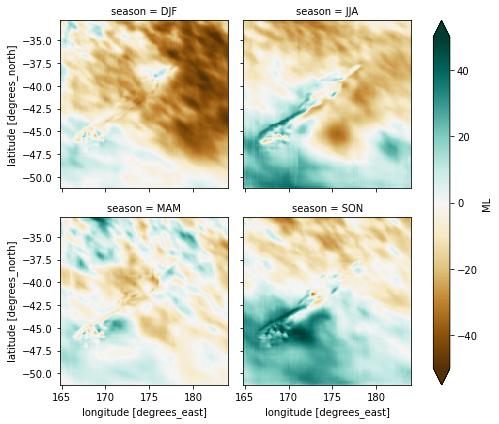

In [50]:
cc_signal_preds.ML.plot(col = "season", col_wrap =2, cmap ='BrBG', vmin =-50, vmax =50)


In [37]:
cc_signal_preds = 100 *(df.sel(time = slice("2080","2099")).groupby('time.season').mean() - df.sel(time = slice("1986","2005")).groupby('time.season').mean())/df.sel(time = slice("1986","2005")).groupby('time.season').mean()

In [25]:
rx1day_true = y.groupby('time.year').max()

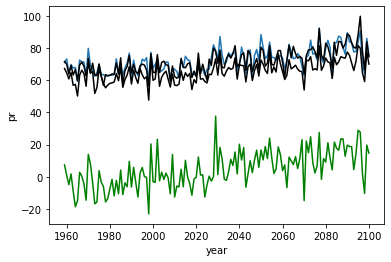

In [359]:
rx1day_true.mean(["lat","lon"]).pr.plot()
rx1day_gcm.mean(["lat","lon"]).pr.plot(color ='g')
rx1day_gan_imperfect.mean(["lat","lon"]).pr.plot(color='k')
rx1day_gan_perfect.mean(["lat","lon"]).pr.plot(color='k')

In [394]:
rx1day_climo_true =100 * (rx1day_true - rx1day_true.sel(year = slice(1985,2006)).mean("year"))/rx1day_true.sel(year = slice(1985,2006)).mean("year")

In [395]:
rx1day_unet =100 * (rx1day_unet - rx1day_unet.sel(year = slice(1985,2006)).mean("year"))/rx1day_unet.sel(year = slice(1985,2006)).mean("year")

In [396]:
rx1day_perfect =100 * (rx1day_gan_perfect - rx1day_gan_perfect.sel(year = slice(1985,2006)).mean("year"))/rx1day_gan_perfect.sel(year = slice(1985,2006)).mean("year")

In [397]:
rx1day_imperfect =100 * (rx1day_gan_imperfect - rx1day_gan_imperfect.sel(year = slice(1985,2006)).mean("year"))/rx1day_gan_imperfect.sel(year = slice(1985,2006)).mean("year")

In [426]:
rx1day_gcm =100 * (rx1day_gcm - rx1day_gcm.sel(year = slice(1985,2006)).mean("year"))/rx1day_gcm.sel(year = slice(1985,2006)).mean("year")

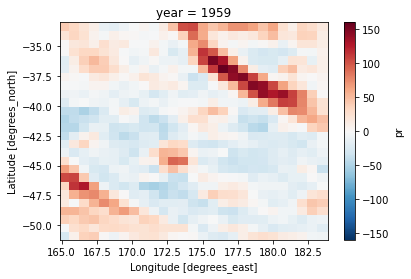

In [427]:
rx1day_gcm.pr.isel(year =0).plot()

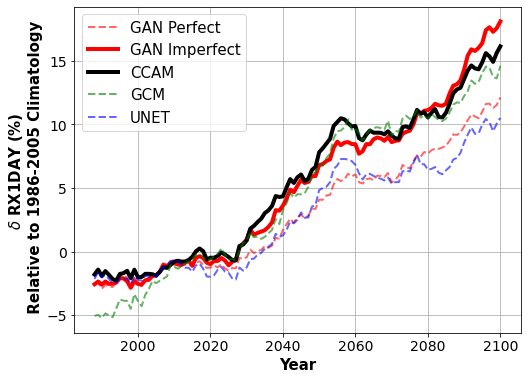

In [449]:
fig, ax = plt.subplots(figsize = (8, 6))
rx1day_perfect.mean(["lat","lon"]).pr.rolling(year =30).mean().plot(color ='r', label ='GAN Perfect', ls ='--', lw =2, alpha =0.6,ax = ax)
rx1day_imperfect.mean(["lat","lon"]).pr.rolling(year =30).mean().plot(color ='r', label ='GAN Imperfect', ls ='-', lw =4, ax = ax)
rx1day_climo_true.mean(["lat","lon"]).pr.rolling(year =30).mean().plot(color ='k', label = 'CCAM', lw =4, ax = ax)
rx1day_gcm.mean(["lat","lon"]).pr.rolling(year =30).mean().plot(color ='green', label ='GCM', lw =2, ls ='--', alpha =0.6, ax = ax)
rx1day_unet.mean(["lat","lon"]).ML.rolling(year =30).mean().plot(color ='b', label ='UNET', lw =2, ls ='--', alpha =0.6,ax = ax)
ax.legend(fontsize =15)
ax.tick_params(labelsize =14)
ax.set_xlabel('Year', fontsize =15, weight ='bold')
ax.set_ylabel('$\delta$ RX1DAY (%) \n Relative to 1986-2005 Climatology', fontsize =15, weight ='bold')
ax.grid('on')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/rx1day_trend.png', dpi =400, bbox_inches ='tight')

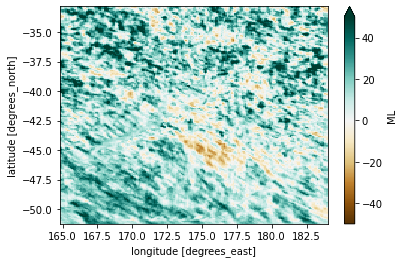

In [56]:
rx1day_climogan.sel(year = slice(2080,2099)).mean("year").ML.plot(vmin =-50, vmax =50, cmap ='BrBG')

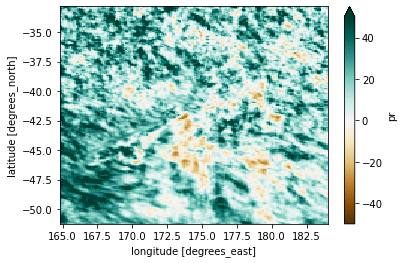

In [31]:
rx1day_climo_true.sel(year = slice(2080,2099)).mean("year").pr.plot(vmin =-50, vmax =50, cmap ='BrBG')

In [152]:
experiment ="CCAM_emulator_pretrained_future_201"
gcm ='EC-Earth3'
dirs = 'raw_CCAM_outputs'#'ml_downscaled_outputs'

In [153]:
hist = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/outputs/ml_downscaled_outputs/{experiment}/{gcm}_historical_ml_downscaled_rainfall_updated_{experiment}.nc')
#hist = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/outputs/{dirs}/{gcm}_historical_precip.nc')

In [154]:
#ssp ='ssp370'
future = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/outputs/ml_downscaled_outputs/{experiment}/{gcm}_{ssp}_ml_downscaled_rainfall_updated_{experiment}.nc')
#future = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/outputs/{dirs}/{gcm}_ssp370_precip.nc')

In [155]:
climo = hist.sel(time = slice("1975","2014")).groupby('time.season').mean()


In [52]:
df = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/inputs/Processed_CMIP6_DATA/Processed_EC-Earth3_ssp370.nc')

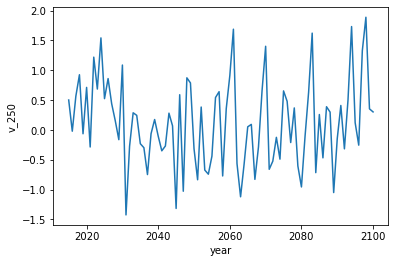

In [122]:
df.v_250.mean(["lat","lon"]).groupby('time.year').mean().plot()

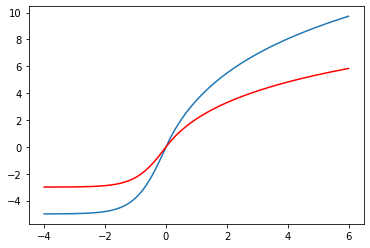

In [466]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
import tensorflow as tf

import tensorflow as tf

def custom_activation(x, beta =3):
    # Ensure x is float type
    alpha =1
    x = tf.cast(x, tf.float32)

    # tanh for x < 1
    tanh_x = tf.tanh(x-1)

    # alpha * log for x > 1, with a small constant added for numerical stability
    log_x = alpha * tf.math.log(x + tf.keras.backend.epsilon())

    # Calculate derivatives of tanh and alpha*log at x=1
    tanh_1 = tf.tanh(1.)
    dtanh_1 = 1. - tanh_1**2
    ddtanh_1 = -2. * tanh_1 * dtanh_1
    log_1 = 0. # alpha * log(1) = 0
    dlog_1 = alpha
    ddlog_1 = -alpha / 1. # second derivative of alpha * log(x) is -alpha / x

    # Coefficients for cubic Hermite spline
    a = (-3. * (tanh_1 - log_1) + dtanh_1 + 2. * dlog_1) / 2.
    b = (2. * (tanh_1 - log_1) - dtanh_1 - dlog_1) / 2.
    c = dtanh_1
    d = tanh_1

    # Cubic Hermite spline for transition at x=1
    transition_x = a * tf.pow((x - 1.), 3) + b * tf.pow((x - 1.), 2) + c * (x - 1.)# + d

    return beta * tf.where(x < 1, tanh_x, tf.where(x > 1, log_x, transition_x))


x = np.arange(-4, 6, 0.010)

plt.plot(x,(custom_activation(x+1, beta=5)))
plt.plot(x,(custom_activation(x+1, beta=3)), color ='r')
# plt.plot(x,6* np.tanh(2*x))
# plt.plot(x,4.25* np.tanh(2*x))
#plt.plot(np.diff(custom_activation(x)))
#plt.plot(np.diff(np.tanh(x-1)))
#plt.plot(x, 2 * x)
#plt.plot(x, 5 * np.tanh(x/2))

In [ ]:
# der

In [156]:
climo_fmuture= future.sel(time = slice("2060","2100")).groupby('time.season').mean()

In [157]:

anom = 100* (climo_fmuture - climo)/climo

In [125]:
anom

<xarray.Dataset>
Dimensions:  (lon: 179, lat: 172, season: 4)
Coordinates:
  * lon      (lon) float32 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0
  * lat      (lat) float32 -51.21 -51.11 -51.0 -50.89 ... -33.07 -32.97 -32.86
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    pr       (season, lat, lon) float32 11.13 11.26 10.98 ... -17.4 -15.26

In [84]:
import numpy as np

In [97]:
ls = LightSource(azdeg=315, altdeg=45)

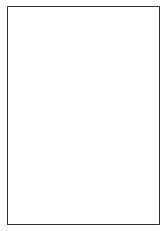

In [101]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.colors import LightSource

# Create a Stamen Terrain instance
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure()

# Create a GeoAxes in the tile's projection
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range
ax.set_extent([166, 179, -48, -34], crs=ccrs.PlateCarree())

# Add the Stamen data at zoom level 8
#img, extent = stamen_terrain.image_for_domain(ax.get_extent(crs=ccrs.PlateCarree()), 8)
#ls = LightSource(azdeg=315, altdeg=45)
#rgb = ls.shade(np.flipud(img.read()), cmap=plt.get_cmap('terrain'), blend_mode='overlay')
#ax.imshow(rgb, origin='upper', extent=extent, transform=stamen_terrain.crs, interpolation='spline36')

#plt.show()

In [102]:
stamen_terrain.image_for_domain(ax.get_extent(crs=ccrs.PlateCarree()), 8)

AttributeError: 'tuple' object has no attribute '_geom'

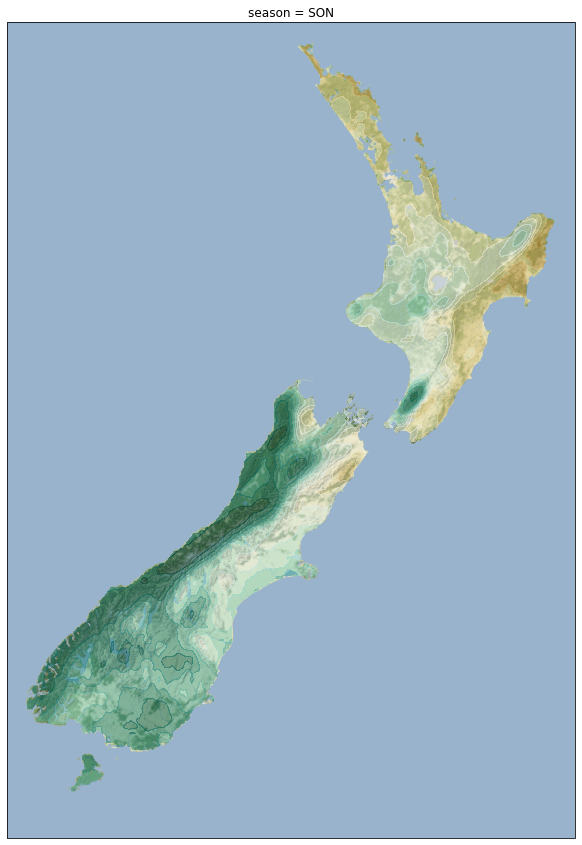

In [103]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

# Create a Stamen Terrain instance
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize = (15, 15))

# Create a GeoAxes in the tile's projection
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range
ax.set_extent([166, 179, -48, -34], crs=ccrs.PlateCarree())

# Add the Stamen data at zoom level 8
ax.add_image(stamen_terrain, 8)
cs = anom[experiment].sel(season=season).plot.contourf(ax=ax, cmap='BrBG',levels = levels, 
                                             transform=ccrs.PlateCarree(), add_colorbar=False, extend ='both', zorder =2, alpha =0.5)
plt.show()

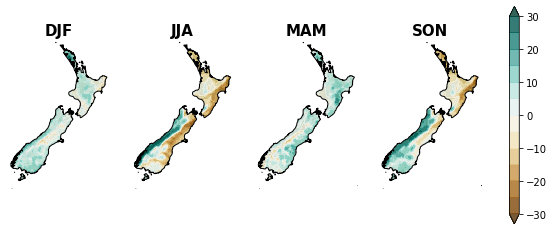

In [158]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
#experiment ='pr'
# Create a Stamen Terrain instance
stamen_terrain = cimgt.Stamen('terrain-background')
# We will use PlateCarree projection, you may change this as per your requirements
projection = ccrs.PlateCarree()
import cartopy.feature as cfeature
# Define figure and axes using plt.subplots
fig, ax = plt.subplots(1, 4, subplot_kw={'projection':  stamen_terrain.crs}, figsize = (10, 4))

# Flattening the axis for easy iteration
ax = ax.flatten()
levels = np.arange(-30, 35, 5)
# Define seasons
seasons = ['DJF', 'JJA', 'MAM', 'SON']

for i, season in enumerate(seasons):
    # Plot data for a specific season
    cs = anom[experiment].sel(season=season).plot.contourf(ax=ax[i], cmap='BrBG',levels = levels, 
                                             transform=ccrs.PlateCarree(), add_colorbar=False, extend ='both', alpha =0.8, zorder =2)
    #ax[i].add_feature(cfeature.LAND, facecolor=cfeature.COLORS['land'], zorder=0)
    ax[i].set_extent([166, 179, -48, -34], crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.OCEAN.with_scale('10m'), fc ='white',ec ='k', zorder =5)
                    

    # Add the Stamen data at zoom level 8
    ax[i].add_image(stamen_terrain, 8)
    # Add coastlines
    #ax[i].coastlines()
    
    # Set title for each subplot
    ax[i].set_title(season, weight ='bold', fontsize = 15)
    
    # Remove borders (spines)
    for spine in ax[i].spines.values():
        spine.set_visible(False)

# Add a single colorbar
fig.colorbar(cs, ax=ax, location='right', fraction=.1)
#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/outputs/CCAM_signal_EC-Earth3_RCM_emulator_Hist.png', dpi =300,bbox_inches ='tight')
#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/outputs/CCAM_signal_EC-Earth3_Hist_RCM_emulator.png', dpi =300,bbox_inches ='tight')
plt.show()

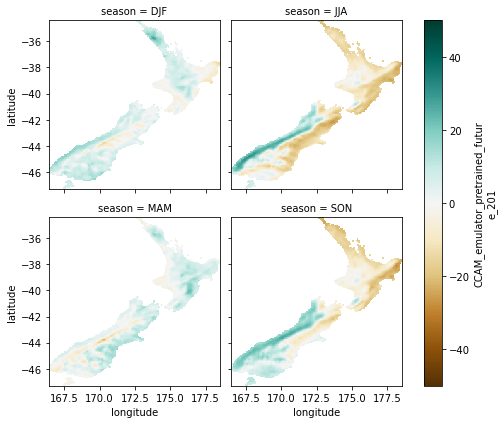

In [68]:
anom[experiment].plot(col ="season", col_wrap =2, cmap ='BrBG', vmin =-50, vmax =50)

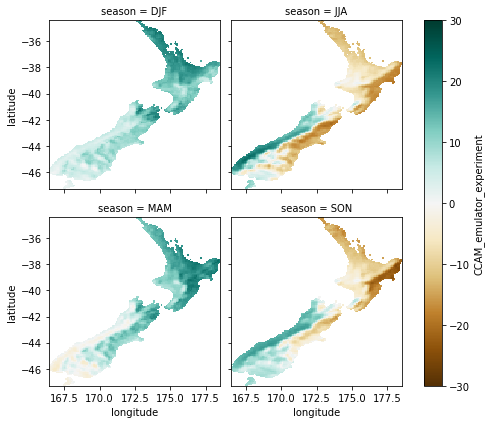

In [115]:
anom[experiment].plot(col ="season", col_wrap =2, cmap ='BrBG', vmin =-30, vmax =30)

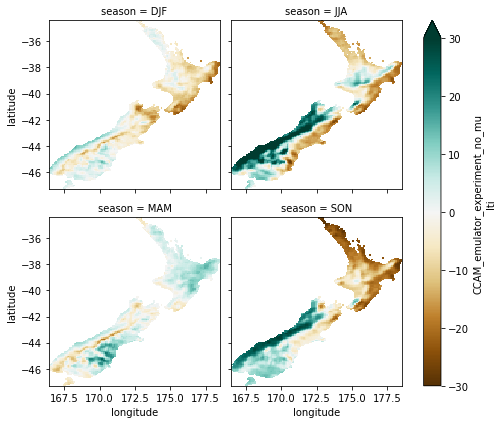

In [102]:
anom[experiment].plot(col ="season", col_wrap =2, cmap ='BrBG', vmin =-30, vmax =30)

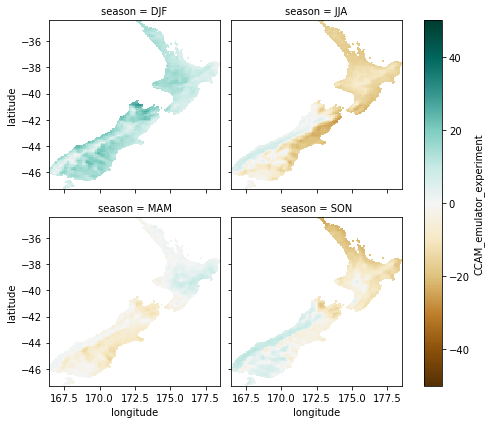

In [14]:
anom['CCAM_emulator_experiment'].plot(col ="season", col_wrap =2, cmap ='BrBG', vmin =-50, vmax =50)

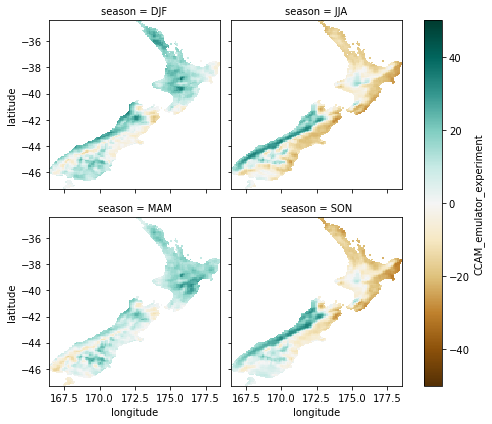

In [68]:
anom['CCAM_emulator_experiment'].plot(col ="season", col_wrap =2, cmap ='BrBG', vmin =-50, vmax =50)

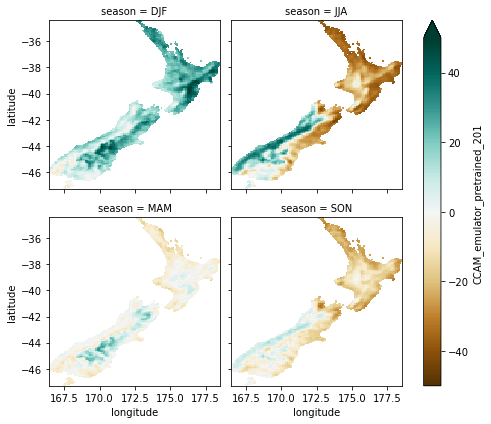

In [55]:
anom['CCAM_emulator_experiment'].plot(col ="season", col_wrap =2, cmap ='BrBG', vmin =-50, vmax =50)

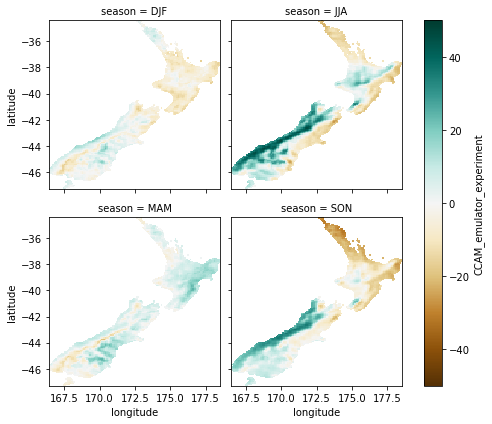

In [29]:
anom['CCAM_emulator_experiment'].plot(col ="season", col_wrap =2, cmap ='BrBG', vmin =-50, vmax =50)

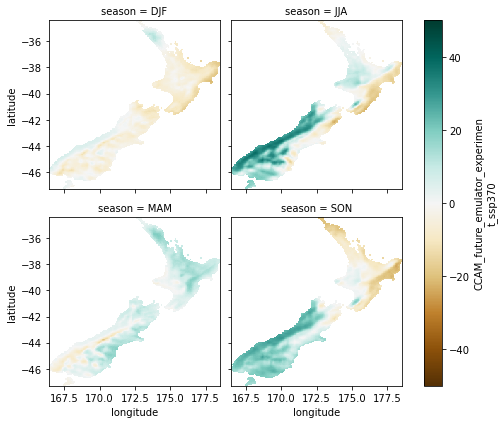

In [21]:
anom['CCAM_future_emulator_experiment_ssp370'].plot(col ="season", col_wrap =2, cmap ='BrBG', vmin =-50, vmax =50)